In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.decomposition import TruncatedSVD
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import zipfile

### Load data

In [4]:
files = np.load('../sirius/all_files.npy')
texts = np.load('../sirius/all_texts.npy')
image_features = np.load('../sirius/all_image_features.npy')
text_features = np.load('../sirius/all_text_features.npy')

train_image = np.load('./2021.07.30 - COCO CLIP embeddings/train_coco_image_embeddings.npy')
train_text = np.load('./2021.07.30 - COCO CLIP embeddings/train_coco_text_embeddings.npy')
val_image = np.load('./2021.07.30 - COCO CLIP embeddings/val_coco_image_embeddings.npy')
val_text = np.load('./2021.07.30 - COCO CLIP embeddings/val_coco_text_embeddings.npy')

In [5]:
print(train_image.shape)
print(train_text.shape)
print(val_image.shape)
print(val_text.shape)

(118287, 512)
(591753, 512)
(5000, 512)
(25014, 512)


### Top-1 Accuracy Init

In [6]:
text_probs = (100.0 *text_features @ image_features.T)
accuracy_score(np.arange(text_probs.shape[0]), text_probs.argmax(axis=1))

0.2418

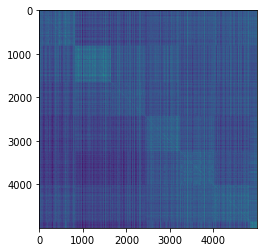

0.325

In [7]:
image_features_norm = normalize(image_features, axis=1, norm='l2')
text_features_norm = normalize(text_features, axis=1, norm='l2')

text_probs = (image_features_norm  @ text_features_norm.T)
plt.imshow(text_probs.astype('float32'), vmin=0.1, vmax=0.3)
plt.show()
accuracy_score(np.arange(text_probs.shape[0]), text_probs.argmax(axis=1))

### PCA

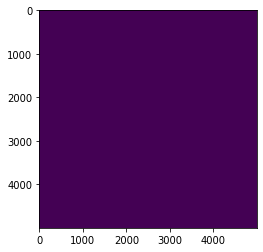

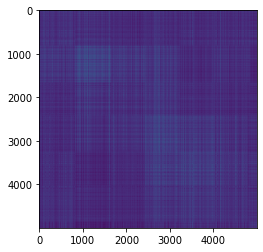

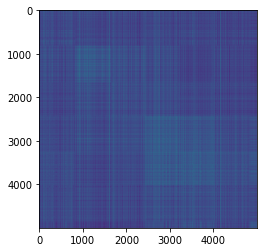

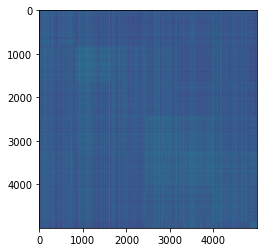

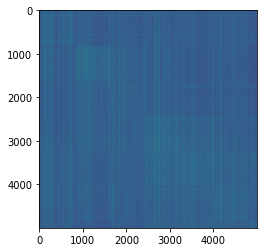

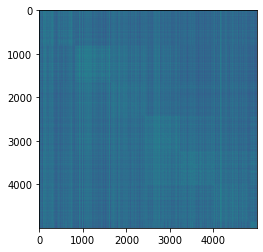

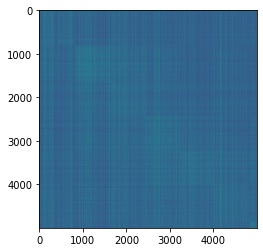

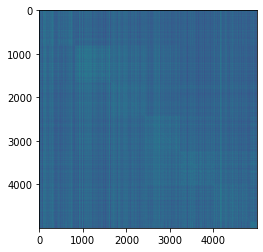

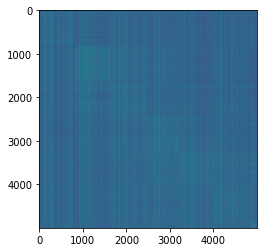

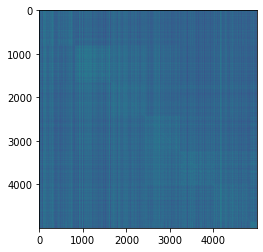

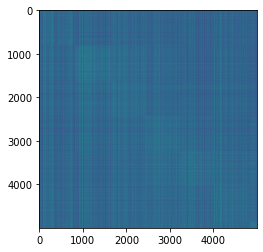

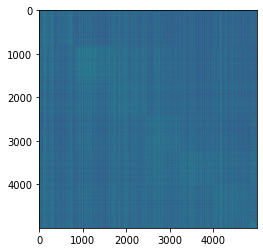

In [8]:
dims = [1, 4, 8, 16, 32, 64, 128, 164, 196, 228, 256, 511]
# dims = [16]
scores_pca = np.zeros(len(dims))
for i, d in enumerate(dims):
    pca = PCA(n_components=d, random_state=42)
    pca.fit(np.concatenate((image_features_norm, text_features_norm), axis=0))
    img_feat_trans = pca.transform(image_features_norm)
    text_feat_trans = pca.transform(text_features_norm)
    img_feat_trans = normalize(img_feat_trans, axis=1, norm='l2')
    text_feat_trans = normalize(text_feat_trans, axis=1, norm='l2')
    text_probs = img_feat_trans @ text_feat_trans.T
    plt.imshow(text_probs)
    plt.show()
    acc = accuracy_score(np.arange(text_probs.shape[0]), text_probs.argmax(axis=1))
    scores_pca[i] = acc
    

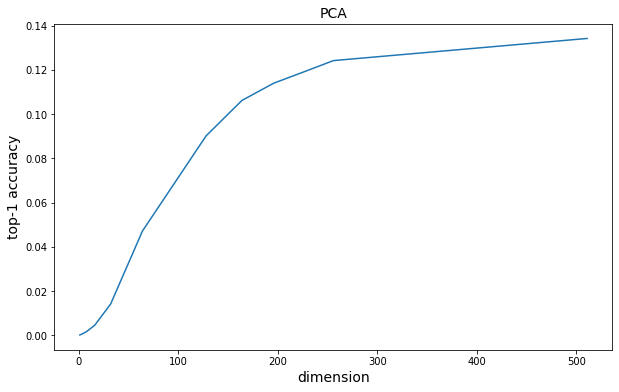

In [9]:
plt.figure(figsize=(10,6))
plt.plot(dims, scores_pca)
plt.title('PCA', fontsize=14)
plt.xlabel('dimension', fontsize=14)
plt.ylabel('top-1 accuracy', fontsize=14);

### Truncated SVD

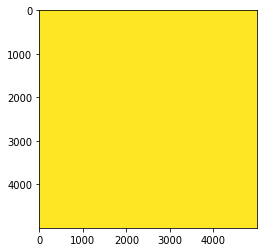

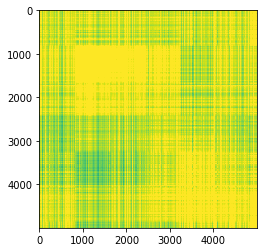

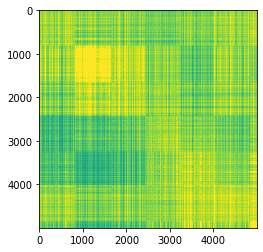

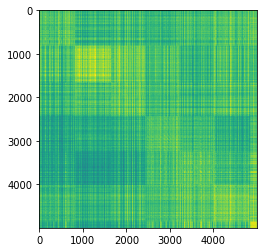

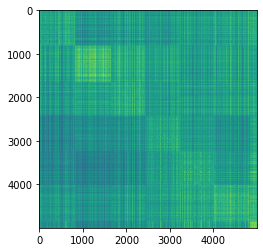

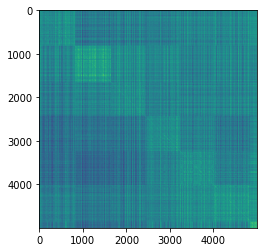

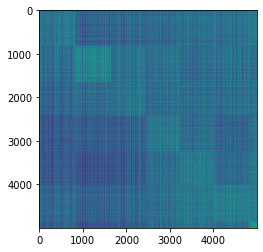

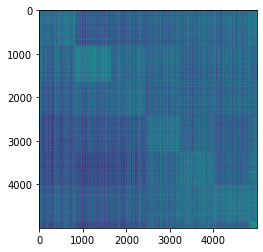

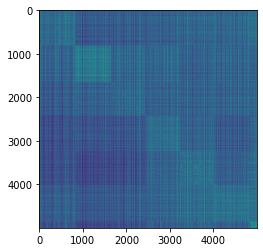

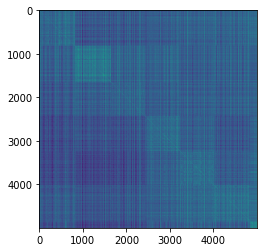

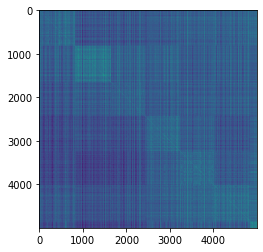

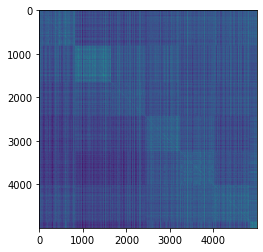

In [10]:
scores_svd = np.zeros(len(dims))
for i, d in enumerate(dims):
    svd = TruncatedSVD(n_components=d, random_state=0)
    svd.fit(np.concatenate((image_features_norm, text_features_norm), axis=0))
    img_feat_trans = svd.transform(image_features_norm)
    text_feat_trans = svd.transform(text_features_norm)
    img_feat_trans = normalize(img_feat_trans, axis=1, norm='l2')
    text_feat_trans = normalize(text_feat_trans, axis=1, norm='l2')
    text_probs = img_feat_trans @ text_feat_trans.T
    plt.imshow(text_probs, vmin=0.1, vmax=0.3)
    plt.show()
    acc = accuracy_score(np.arange(text_probs.shape[0]), text_probs.argmax(axis=1))
    scores_svd[i] = acc

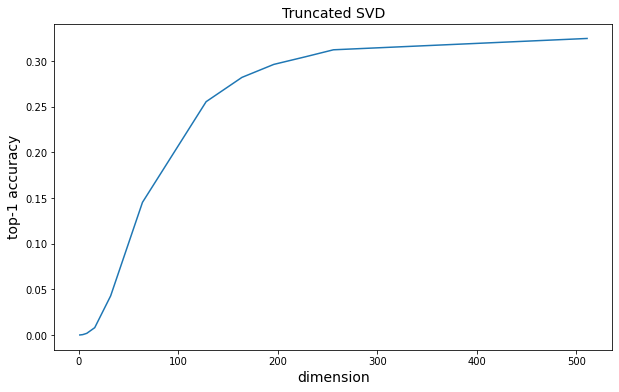

In [11]:
plt.figure(figsize=(10,6))
plt.plot(dims, scores_svd)
plt.title('Truncated SVD', fontsize=14)
plt.xlabel('dimension', fontsize=14)
plt.ylabel('top-1 accuracy', fontsize=14);

### Random projection

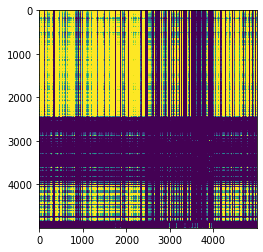

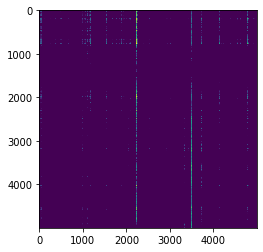

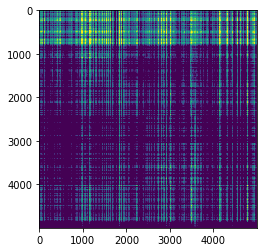

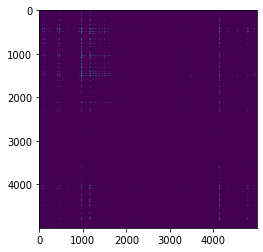

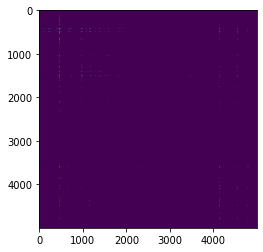

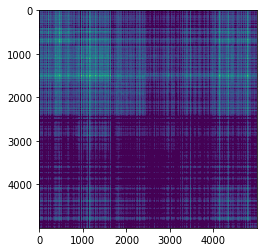

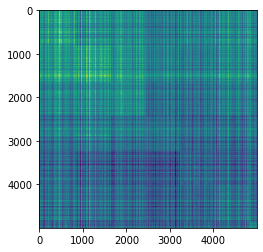

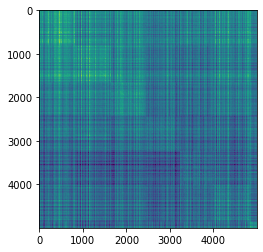

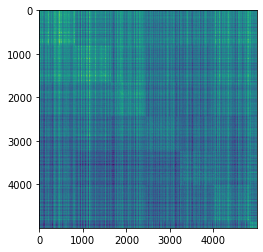

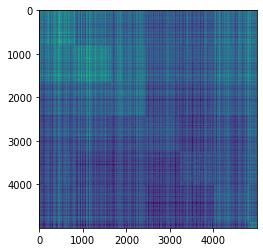

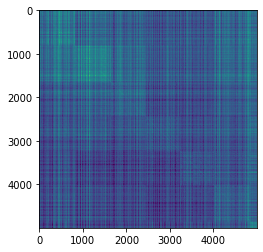

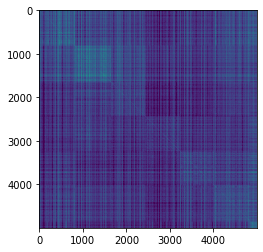

In [12]:
scores_rp = np.zeros(len(dims))
for i, d in enumerate(dims):
    grp = GaussianRandomProjection(n_components=d, random_state=0)
    grp.fit(np.concatenate((image_features_norm, text_features_norm), axis=0))
    img_feat_trans = grp.transform(image_features_norm)
    text_feat_trans = grp.transform(text_features_norm)
    img_feat_trans = normalize(img_feat_trans, axis=1, norm='l2')
    text_feat_trans = normalize(text_feat_trans, axis=1, norm='l2')
    text_probs = img_feat_trans @ text_feat_trans.T
    plt.imshow(text_probs, vmin=0.1, vmax=0.3)
    plt.show()
    acc = accuracy_score(np.arange(text_probs.shape[0]), text_probs.argmax(axis=1))
    scores_rp[i] = acc

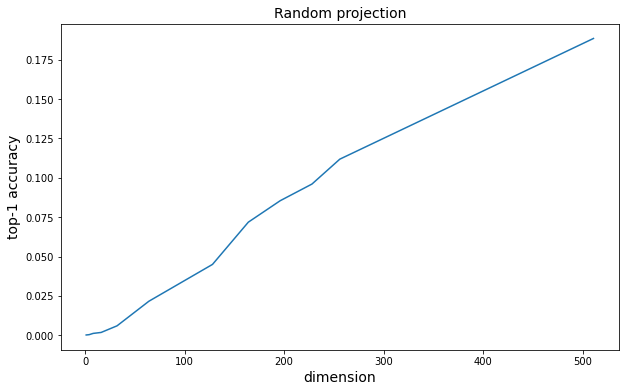

In [13]:
plt.figure(figsize=(10,6))
plt.plot(dims, scores_rp)
plt.title('Random projection', fontsize=14)
plt.xlabel('dimension', fontsize=14)
plt.ylabel('top-1 accuracy', fontsize=14);

### AutoEncoder

In [14]:
import torch.nn as nn
import torch.utils.data as torch_data
from sklearn.model_selection import train_test_split

In [8]:
hidden_dim = 196
class AE(nn.Module):
    def __init__(self, hidden_dim):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(512, 484),
#                                     nn.BatchNorm1d(484),
                                    nn.ReLU(inplace=True),
#                                     nn.Dropout(0.2),
                                    nn.Linear(484, 256),
#                                     nn.BatchNorm1d(256),
                                    nn.ReLU(inplace=True),
#                                     nn.Dropout(0.2),
                                    nn.Linear(256, hidden_dim),
                                    )  
        self.decoder = nn.Sequential(
                                    nn.Linear(hidden_dim, 256),
#                                     nn.BatchNorm1d(256),
                                    nn.ReLU(inplace=True),
#                                     nn.Dropout(0.2),
                                    nn.Linear(256, 484),
#                                     nn.BatchNorm1d(484),
                                    nn.ReLU(inplace=True),
#                                     nn.Dropout(0.2),
                                    nn.Linear(484, 512)
                                    )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [24]:
train_losses = []
val_losses = []
acc_hist = []
def train(epochs, net, criterion, train_loader, val_loader, verbose=True):
    
    freq = max(epochs//20,1)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) 
    net.to(device)
    
    for epoch in range(1, epochs+1):
        net.train()
        losses_train = []
        for X in train_loader:
            
            X = X.to(device)
            out = net(X)
            loss = criterion(out, X)
            losses_train.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        net.eval()
        
        losses_val = []
        for X in val_loader:
            X = X.to(device)
            out = net(X)
            val_loss = criterion(out, X)
            losses_val.append(val_loss)

        
        mean_val = sum(losses_val)/len(losses_val)
        mean_train = sum(losses_train)/len(losses_train)

        train_losses.append(mean_train)
        val_losses.append(mean_val)
        
        if verbose and epoch%freq==0:
            
            img_feat_trans = net.encoder(torch.tensor(image_features_norm).float().to(device))
            text_feat_trans = net.encoder(torch.tensor(text_features_norm).float().to(device))
            img_feat_trans = normalize(img_feat_trans.cpu().detach().numpy(), axis=1, norm='l2')
            text_feat_trans = normalize(text_feat_trans.cpu().detach().numpy(), axis=1, norm='l2')
            text_probs = 100.0 * img_feat_trans @ text_feat_trans.T
            acc = accuracy_score(np.arange(text_probs.shape[0]), text_probs.argmax(axis=1))
            
            acc_hist.append(acc)
            print('Epoch {}/{}  Loss:  Train {:.6f} | Validation {:.6f} \t Top-1: {:.6f}'\
                  .format(epoch, epochs, mean_train, mean_val, acc))

In [25]:
torch.manual_seed(0)
device = 'cpu'


model = AE(hidden_dim)  
criterion = nn.MSELoss()

embeds = torch.tensor(np.concatenate((image_features_norm, text_features_norm), axis=0)).float()
embeds_train, embeds_val = train_test_split(embeds, random_state=0, test_size=0.25)


train_loader = torch_data.DataLoader(embeds_train, batch_size=50, shuffle=True) 
val_loader = torch_data.DataLoader(embeds_val, batch_size=50, shuffle=False) 

In [26]:
epochs = 200
train(epochs, model, criterion, train_loader, val_loader) 

Epoch 10/200  Loss:  Train 0.000351 | Validation 0.000366 	 Top-1: 0.090200
Epoch 20/200  Loss:  Train 0.000275 | Validation 0.000305 	 Top-1: 0.134200
Epoch 30/200  Loss:  Train 0.000240 | Validation 0.000278 	 Top-1: 0.149400
Epoch 40/200  Loss:  Train 0.000218 | Validation 0.000258 	 Top-1: 0.157600
Epoch 50/200  Loss:  Train 0.000205 | Validation 0.000248 	 Top-1: 0.159600
Epoch 60/200  Loss:  Train 0.000194 | Validation 0.000240 	 Top-1: 0.158400
Epoch 70/200  Loss:  Train 0.000187 | Validation 0.000234 	 Top-1: 0.164400
Epoch 80/200  Loss:  Train 0.000182 | Validation 0.000230 	 Top-1: 0.171000
Epoch 90/200  Loss:  Train 0.000176 | Validation 0.000224 	 Top-1: 0.173000
Epoch 100/200  Loss:  Train 0.000172 | Validation 0.000218 	 Top-1: 0.169000
Epoch 110/200  Loss:  Train 0.000169 | Validation 0.000217 	 Top-1: 0.175200
Epoch 120/200  Loss:  Train 0.000166 | Validation 0.000214 	 Top-1: 0.171000
Epoch 130/200  Loss:  Train 0.000164 | Validation 0.000212 	 Top-1: 0.175000
Epoch 14

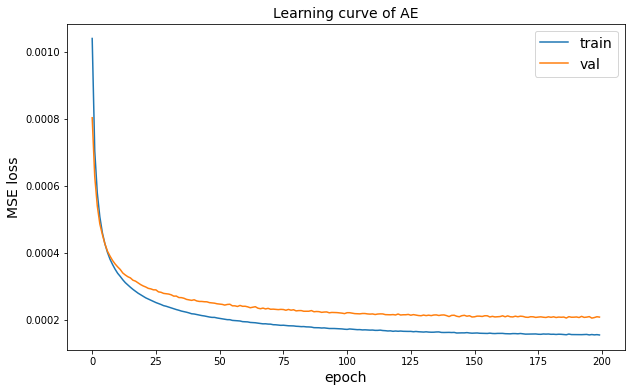

In [27]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(epochs), train_losses, label='train')
plt.plot(np.arange(epochs), val_losses, label='val')
plt.title('Learning curve of AE', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('MSE loss', fontsize=14)
plt.legend(fontsize=14);

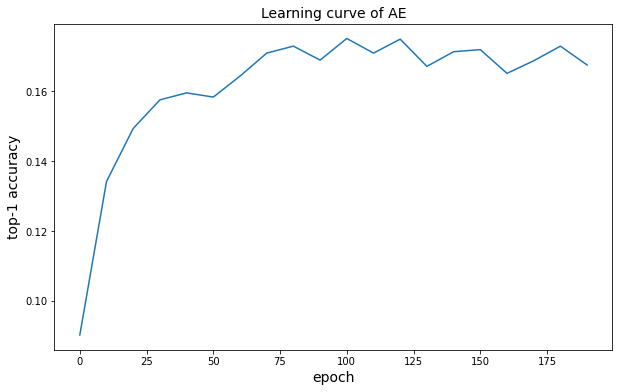

In [33]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(epochs, step=10), acc_hist, label='embed dim = 196')
plt.title('Learning curve of AE', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('top-1 accuracy', fontsize=14);